# Welcome
This project tracks the development of multiple machine learning models aimed to predict fantasy football points for the upcoming 2022-2023 NFL season. All data was scraped from pro-football-reference.com. 

Source code for this analysis can be found as part of my greater project aimed to predict NFL game outcomes and compare to current betting lines at https://github.com/Bernardsj/NFL_Bets

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import sqlalchemy
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_theme()

In [2]:
# Get Data
from sqlalchemy import create_engine
engine = engine = create_engine("mysql://root:eK5ERE<Sqv+j[0o@localhost/nfl_bets")


player_stats = pd.read_sql(
    'SELECT * FROM player_stats_annual', con=engine)

# EDA
The primary data set I will be using was scrapped from https://www.pro-football-reference.com to include player's season total stats and resulting fantsey points. As the league I'm apart of is a PPR league, we will use this scoring system as our predictor variable. 

In [3]:
# First things first - split the data
player_stats_X = player_stats.drop('ppr_points', axis = 1)
player_stats_y = player_stats['ppr_points']

X_train, X_test, y_train, y_test = train_test_split(player_stats_X, player_stats_y, test_size=0.33, random_state=42)

## PPR Points
When examining the breakdown of total points across each season from the year 2000 to 2020 there is a fairly large spread. This shouldn't be suprising as there are a handfull of standout players which produce way more points when compared to league averages. This comparison is even more dramatic when there are players who became injured during the season or acted as a utility player.  

In [4]:
# descriptive statistics summary
y_train.describe()

count    8741.000000
mean       71.180986
std        84.099198
min        -7.000000
25%         6.000000
50%        35.000000
75%       113.000000
max       460.000000
Name: ppr_points, dtype: float64

As expected from the descriptive statistic breakdown, there is a good deal of positive skewness we will likely have to deal with when employing our models, however, skewness and kurtosis aren't terrible. 


Skewness: 1.366658
Kurtosis: 1.203163


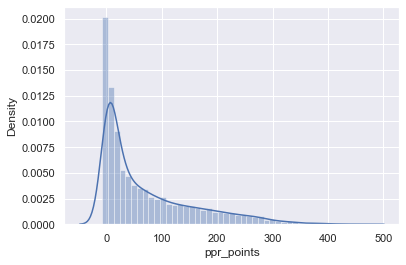

In [5]:
#histogram
sns.distplot(y_train);

#skewness and kurtosis
print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())

In [19]:
# View relationship between features and y
df_train = X_train[X_train.columns.drop(list(X_train.filter(regex='points')))]

# num cols
num_feats = df_train.select_dtypes(include=[np.number])
num_feats_eda = pd.concat([y_train, num_feats], axis = 1)

# dummy cols
dummy_feats = df_train.select_dtypes(include=['object'])
dummy_feats_eda = pd.concat([y_train, dummy_feats], axis = 1)

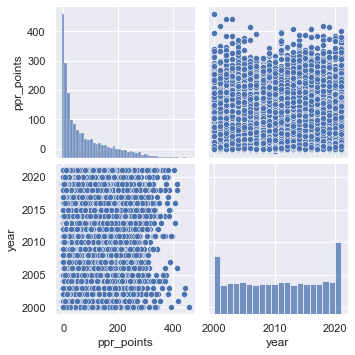

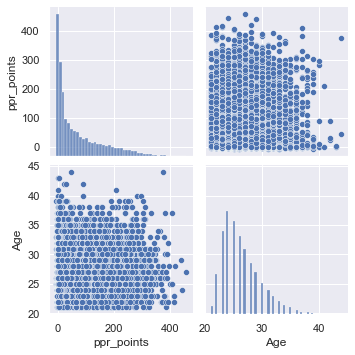

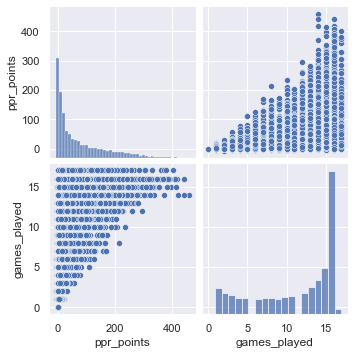

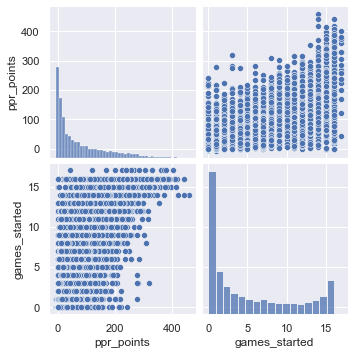

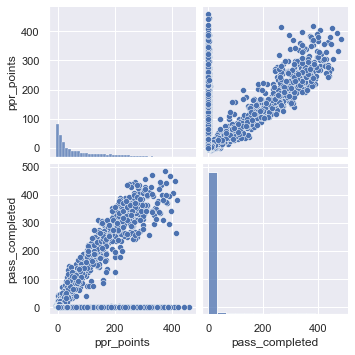

In [53]:
for feat in num_feats_eda.iloc[:, 1:(len(num_feats_eda.columns)+1)]:
    sns.pairplot(num_feats_eda[['ppr_points', str(feat)]], corner = True)

,ppr_points,year,Age,games_played,games_started,pass_completed,pass_attempt,pass_yds,pass_td,pass_int,...,catch_yds,catch_yds_per_att,catch_td,fumbles_total,fumbles_lost,td_total,twopoint_made,twopoint_pass,rank_position,rank_total
1573,81.0,2014,25,7,7,0,0,0,0,0,...,375,15.0,3,0,0,3,0,0,86,0
12136,0.0,2004,25,2,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,1,78
8857,5.0,2015,23,2,0,0,0,0,0,0,...,22,7.0,0,0,0,0,0,0,93,0
2423,93.0,2015,25,13,0,0,0,0,0,0,...,240,7.0,2,2,0,2,0,0,61,0
11524,196.0,2008,25,16,9,0,0,0,0,0,...,1006,13.0,3,1,0,3,0,0,28,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,321.0,2002,27,16,15,0,0,0,0,0,...,597,9.0,0,9,6,11,0,0,8,11
5191,152.0,2007,35,14,12,0,0,0,0,0,...,733,13.0,4,0,0,4,0,0,41,0
5390,6.0,2020,25,16,0,0,0,0,0,0,...,25,8.0,0,0,0,0,0,0,99,0
860,32.0,2006,29,6,0,0,0,0,0,0,...,147,9.0,0,0,0,0,0,0,118,0


In [50]:
len(num_feats_eda.columns)

26

,year,Age,games_played,games_started,pass_completed,pass_attempt,pass_yds,pass_td,pass_int,rush_att,...,td_total,twopoint_made,twopoint_pass,fantsey_points,draftking_points,fanduel_points,vbd_points,rank_position,rank_total,ppr_points
1573,2014,25,7,7,0,0,0,0,0,0,...,3,0,0,56,84.0,68.0,0,86,0,81.0
12136,2004,25,2,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,1,78,0.0
8857,2015,23,2,0,0,0,0,0,0,0,...,0,0,0,2,5.0,4.0,0,93,0,5.0
2423,2015,25,13,0,0,0,0,0,0,35,...,2,0,0,58,99.0,75.0,0,61,0,93.0
11524,2008,25,16,9,0,0,0,0,0,2,...,3,0,0,119,199.0,158.0,3,28,73,196.0


In [53]:
pd.concat([df_train.ppr_points, df_train.games_started, df_train.fantasy_position], axis = 1)


,ppr_points,games_started,fantasy_position
1573,81.0,7,WR
12136,0.0,0,
8857,5.0,0,TE
2423,93.0,0,RB
11524,196.0,9,WR
...,...,...,...
11964,321.0,15,RB
5191,152.0,12,WR
5390,6.0,0,TE
860,32.0,0,WR
